<a href="https://colab.research.google.com/github/simecek/PseudoDNA_Generator/blob/master/models/Intergenomic_AWD_LSTM_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install fastai2>=0.0.11 ipywidgets matplotlib nbdev>=0.2.12 pandas scikit_learn sentencepiece

In [2]:
from fastai2.text.all import *
import pandas as pd
import torch

In [3]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name(0)

(True, 1, 'Tesla P100-PCIE-16GB')

In [4]:
# Mount to your Google Drive allowing lesson files will be saved to your Drive location
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
dt = pd.read_csv("/content/drive/My Drive/data/random/intergenomic_seqs_50k.csv")
dt = dt[~dt.seq.str.contains("N")]   # just for sure

train = dt[dt.chr!="1"]
test = dt[dt.chr=="1"]

print(dt.shape, train.shape, test.shape)
dt.head()

(50000, 4) (46286, 4) (3714, 4)


,chr,start,end,seq
0,17,14239397,14239596,AACTGGGATTCACAGGAGCTTAATGGAGCACATGATGTTAAGTGAAGTGAGCCAGGCACAAAAAGACAACTACCACGTGATCTGACTTATGTGGAATGTAAAACAATTGAACTCATGGAAGCAGAGAGTAGAATGGAGGATACCAGGGGCTGGGAGGCAGGGGTTTGGGGAGACGGTGAAAGCGTTCTAAAGTGTAGTTA
1,X,90928374,90928573,GCTAGTTGTATGGTTAGCAGCAAGATATTTTTTCTCTCTGATCTTTAATTTTCATATTTAAATTTGGCTAAGAGTACTTGCCTCTTAAAACTGTGTTGCTGGTATTACCAGAGTGTGGTATAATTAAAATATATATTTGCTTTTTGTCACCAGTTTCTCACACAGTACATCAAAAGCCCTTGCAATTTTCTGAGTGATAA
2,3,104278717,104278916,GACTTTGTAGACTTGTGTGACCTGTGTGCCTCCCTCTCCCCCCAAAAAAAACAAAAAAAATAAAGGATCTTGGGAAAGACTATATAAAAGGCAAGACTCCTTTAATGGAGGGGATATGCTAGATTGCCTCCCATTATGGCCCATGCCAAAGTGTTTAAACTTAGAAAAATGGTTCCAGTTTACTTCTGGGCTTAAAAATC
3,4,187089054,187089253,ATGTTAACACCAAATCAGTCCATCCTAATTATCACTCAAAAATCAAACATTTTTTAGGGAGGCAAAAACTGTCATGAGAACTACAATTTGATTTGGAGACTATTTCACTTATACAGTTTCTTCACATGATGACCAGCCTTCTTTCTTTAGTAATGGTTATTACTATGGCCATTGCTGTTAATTCTGTGACTTATCACTTC
4,2,137742849,137743048,GCAGGAGCTCTATCTGTTTGGACTAGTTCAGCCCCATCTCTTTTGGGGTGACTCGGGTGATGCTAAGCTTCCCAGGGCCATTGTGTTCTGTCTTCTGCCTCTGACTTTTTCCCTGCTACCCACATGAGCTTCTGCTATGCTCTCTTCTTTCCTGTCCAGAAATCATGTAGTAAGATGCTTTTTGGCTGGAGACCCTGAAA


In [6]:
!rm -rf split_tok

!rm -rf split
!mkdir split
!mkdir split/train
!mkdir split/valid
!mkdir split/train/1/
!mkdir split/valid/1/

In [7]:
# splitting the file into training and test part
N = len(dt.seq)

for i, s in enumerate(train.seq):
  open("split/train/1/seq"+str(i)+".txt", 'w').writelines([s])
for i, s in enumerate(test.seq):
  open("split/valid/1/seq"+str(i)+".txt", 'w').writelines([s])

## Tokenizer

In [8]:
!wget https://raw.githubusercontent.com/simecek/PseudoDNA_Generator/master/models/genomic_tokenizer2.py

--2020-06-20 23:18:07--  https://raw.githubusercontent.com/simecek/PseudoDNA_Generator/master/models/genomic_tokenizer2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565 [text/plain]
Saving to: ‘genomic_tokenizer2.py’

genomic_tokenizer2. 100%[===================>]     565  --.-KB/s    in 0s      

2020-06-20 23:18:07 (40.7 MB/s) - ‘genomic_tokenizer2.py’ saved [565/565]



In [9]:
from genomic_tokenizer2 import tkn2

## Data Loaders

In [10]:
dls_lm = TextDataLoaders.from_folder(Path("./split"), bs=128, seed=42, 
                                   is_lm=True, 
                                   tok_tfm=tkn2, seq_len=50)

In [11]:
dls_lm.show_batch()

,text,text_
0,A C A A C A C C T C T C C A G C A A G G G T A C C G A A C T G G A T G G C A G A T G A G T T G G A C,C A A C A C C T C T C C A G C A A G G G T A C C G A A C T G G A T G G C A G A T G A G T T G G A C A
1,A A G C T T C C A C T G C T T C T T C C C A C A C A G A G A A C T A C C T T C A G T G C A T A C A A,A G C T T C C A C T G C T T C T T C C C A C A C A G A G A A C T A C C T T C A G T G C A T A C A A C
2,A T G G T C T T T A A C A G G G T T T T G G T A G G G A C A T G G T A G A G G C T G G T T C C T A A,T G G T C T T T A A C A G G G T T T T G G T A G G G A C A T G G T A G A G G C T G G T T C C T A A A
3,G A A T T T T G A T T G G A A A C A A A G G A A A G A A A A A G T G C A T A A C C C G G G A A G C G,A A T T T T G A T T G G A A A C A A A G G A A A G A A A A A G T G C A T A A C C C G G G A A G C G G
4,T T C T T C A G C C T A A C C A T G T T G A G T C C C A A A A T T T A G G T T T T T T G T A A C C T,T C T T C A G C C T A A C C A T G T T G A G T C C C A A A A T T T A G G T T T T T T G T A A C C T C
5,T G A T C T G C C C G C C T C G G T C T C C T A A A G T G C T G G G A T T A C A G G C A T A A G C C,G A T C T G C C C G C C T C G G T C T C C T A A A G T G C T G G G A T T A C A G G C A T A A G C C A
6,A A A A A C T A C T T T A A A G T T C A T A T G A A A C C A A A G A A G A G C C T G T G T T G C C A,A A A A C T A C T T T A A A G T T C A T A T G A A A C C A A A G A A G A G C C T G T G T T G C C A A
7,A A C A T G A T A C T A A G T G A A A T A A G A A A G C C A C A A A A A G A C A A A T A C T G T A T,A C A T G A T A C T A A G T G A A A T A A G A A A G C C A C A A A A A G A C A A A T A C T G T A T A
8,T C A G G A A A T A C A A A G A A C A T C A C A A A G A T A C T C C T T C C T G A G T G C T G G G A,C A G G A A A T A C A A A G A A C A T C A C A A A G A T A C T C C T T C C T G A G T G C T G G G A T


## Model and Learning

In [12]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, pretrained=False, 
    metrics=[accuracy, Perplexity()])

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=0.010964781977236271)

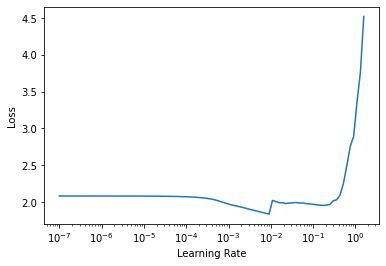

In [13]:
learn.lr_find()

In [14]:
learn.fit_one_cycle(10, 1e-2)
learn.export("/content/drive/My Drive/DNAModels/Intergenomic/AWD_LSTM_v6.pkl")

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.319026,1.317057,0.356335,3.732421,05:53
1,1.268806,1.267198,0.395128,3.550891,05:52
2,1.238815,1.240738,0.407204,3.458166,05:51
3,1.236883,1.230025,0.414033,3.421314,05:51
4,1.225663,1.223441,0.417613,3.398863,05:50
5,1.206722,1.213210,0.422614,3.364266,05:51
6,1.202842,1.205860,0.426965,3.339630,05:49
7,1.193184,1.200213,0.429974,3.320825,05:49
8,1.185562,1.197221,0.432011,3.310902,05:49
9,1.181196,1.196629,0.432396,3.308943,05:49
